<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/ML-2025/blob/main/Week_07/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym==0.26.2 numpy==1.23.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 29.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 62.8 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827727 sha256=4c82664ff9f0bb8310f77e53994301aae5ccc44672d090b3b66d58cb4570b2e1
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [20]:
# Hyperparameters
LR = 3e-4
GAMMA = 0.99
CLIP_EPSILON = 0.2
EPOCHS = 4
BATCH_SIZE = 64
EPISODES = 300

VIS_EPISODES = 5

In [4]:
# Actor-Critic Network (unchanged)
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc(x)
        return torch.softmax(self.actor(x), dim=-1), self.critic(x)

# PPO Agent (updated step handling)
class PPO:
    def __init__(self, env):  # Add __init__ method
        self.env = env
        self.model = ActorCritic(env.observation_space.shape[0], env.action_space.n)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.returns = []  # Track returns

    def update(self, states, actions, advantages, returns, old_log_probs):
        for _ in range(EPOCHS):  # Outer loop starts here
            # Correct indentation for inner loop
            for idx in range(0, len(states), BATCH_SIZE):  # <-- Indent this block
                b_states = states[idx:idx+BATCH_SIZE]
                b_actions = actions[idx:idx+BATCH_SIZE]
                b_advantages = advantages[idx:idx+BATCH_SIZE]
                b_returns = returns[idx:idx+BATCH_SIZE]
                b_old_log_probs = old_log_probs[idx:idx+BATCH_SIZE]

                # Compute new log probs and values
                probs, values = self.model(b_states)
                dist = torch.distributions.Categorical(probs)
                new_log_probs = dist.log_prob(b_actions)
                entropy = dist.entropy().mean()

                # Clipped surrogate loss
                ratio = (new_log_probs - b_old_log_probs).exp()
                surr1 = ratio * b_advantages
                surr2 = torch.clamp(ratio, 1-CLIP_EPSILON, 1+CLIP_EPSILON) * b_advantages
                actor_loss = -torch.min(surr1, surr2).mean()

                # Critic loss
                critic_loss = (b_returns - values.squeeze()).pow(2).mean()

                # Total loss
                loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy

                # Update
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def train(self, max_episodes=300):
        for episode in range(max_episodes):
            states, actions, rewards, log_probs = [], [], [], []
            state, _ = self.env.reset()  # Reset returns (obs, info)
            done = False

            # Collect trajectory (updated step unpacking)
            while not done:
                state = torch.FloatTensor(state)
                with torch.no_grad():
                    prob, value = self.model(state)
                dist = torch.distributions.Categorical(prob)
                action = dist.sample()
                log_prob = dist.log_prob(action)

                # Handle new step API: 5 return values
                next_state, reward, terminated, truncated, _ = self.env.step(action.item())
                done = terminated or truncated  # Combine flags

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                state = next_state

            # Compute returns and advantages (unchanged)
            returns = []
            R = 0
            for r in reversed(rewards):
                R = r + GAMMA * R
                returns.insert(0, R)
            returns = torch.tensor(returns)
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Update network
            self.update(
                torch.stack(states),
                torch.stack(actions),
                returns,
                returns,
                torch.stack(log_probs)
            )

            total_return = sum(rewards)
            self.returns.append(total_return)  # Store return

            if episode % 10 == 0:
                print(f"Episode {episode}, Return: {total_return}")

    def visualize(self, num_episodes=3):
        for _ in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                state_tensor = torch.FloatTensor(state)
                with torch.no_grad():
                    prob, _ = self.model(state_tensor)
                action = torch.argmax(prob).item()

                state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                total_reward += reward
                self.env.render()

            print(f"Visualization Episode Reward: {total_reward}")
        self.env.close()

    def animate_episode(self, max_steps=500):
        state, _ = self.env.reset()
        frames = []
        done = False
        total_reward = 0

        while not done and len(frames) < max_steps:
            frame = self.env.render()
            frames.append(frame)

            state_tensor = torch.FloatTensor(state)
            with torch.no_grad():
                prob, _ = self.model(state_tensor)
            action = torch.argmax(prob).item()

            state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            total_reward += reward

        self.env.close()

        fig = plt.figure(figsize=(6, 4))
        plt.axis('off')
        ims = [[plt.imshow(frame, animated=True)] for frame in frames]
        ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
        plt.close()

        return ani, total_reward

Episode 0, Return: 20.0
Episode 10, Return: 32.0
Episode 20, Return: 35.0
Episode 30, Return: 31.0
Episode 40, Return: 20.0
Episode 50, Return: 33.0
Episode 60, Return: 15.0
Episode 70, Return: 20.0
Episode 80, Return: 42.0
Episode 90, Return: 43.0
Episode 100, Return: 40.0
Episode 110, Return: 28.0
Episode 120, Return: 72.0
Episode 130, Return: 21.0
Episode 140, Return: 16.0
Episode 150, Return: 62.0
Episode 160, Return: 26.0
Episode 170, Return: 37.0
Episode 180, Return: 39.0
Episode 190, Return: 93.0
Episode 200, Return: 54.0
Episode 210, Return: 99.0
Episode 220, Return: 55.0
Episode 230, Return: 71.0
Episode 240, Return: 60.0
Episode 250, Return: 107.0
Episode 260, Return: 224.0
Episode 270, Return: 35.0
Episode 280, Return: 169.0
Episode 290, Return: 248.0


NameError: name 'HTML' is not defined

In [ ]:
# Initialize environment and agent
env = gym.make('CartPole-v1', render_mode='rgb_array')
agent = PPO(env)  # Now works!
agent.train(max_episodes=EPISODES)

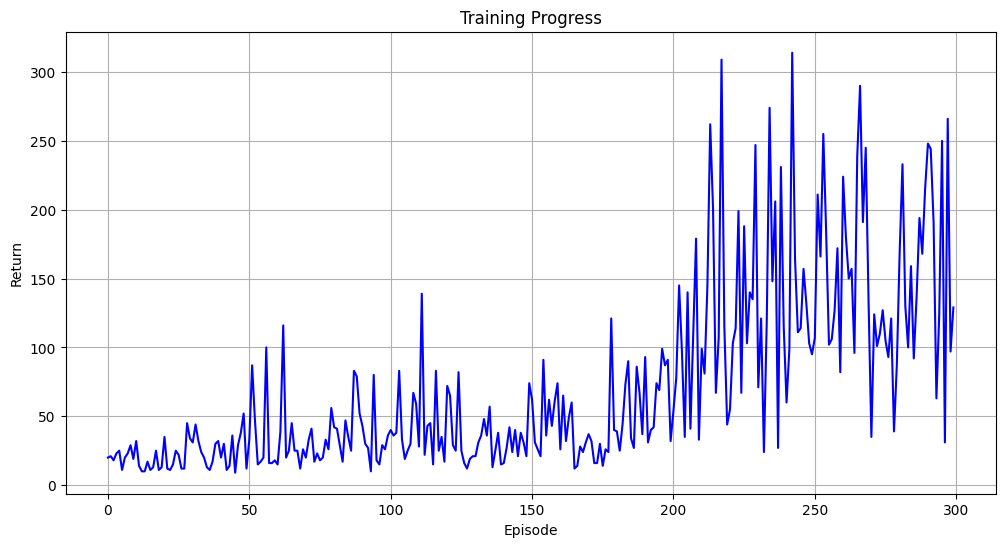

In [11]:
# After training, plot using the stored returns
plt.figure(figsize=(12, 6))
plt.plot(agent.returns, 'b-', label='Raw Returns')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Training Progress')
plt.grid(True)
plt.show()

In [21]:
agent.visualize(num_episodes=VIS_EPISODES)

Visualization Episode Reward: 500.0
Visualization Episode Reward: 500.0
Visualization Episode Reward: 500.0
Visualization Episode Reward: 500.0
Visualization Episode Reward: 500.0


In [22]:
# Generate animation for a successful episode
ani, reward = agent.animate_episode()
# Display in notebook
HTML(ani.to_jshtml())

In [23]:
# Save animation to file
ani.save('cartpole_ppo.gif', writer='pillow', fps=30)